In [1]:
import os
import sys
sys.path.append('..')
os.getcwd()

'/mnt/data/shen/archive/oct/notebooks'

# Preicise cut and paste

In [2]:
# pip install opencv-python
from collections import namedtuple
from glob import glob
from pathlib import Path
from os.path import join
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from idp_utils.visualization import visualize_segmentation, plot_horizontal
from idp_utils.data_handling.mask import expand_label, get_dst_shadow
import idp_utils.data_handling.constants as C

In [3]:
%cd $C.ROOT_PATH

/mnt/data/shen/archive/oct


### Randomly choose source and target

These codes are moved to `idp_tuils.data_handling.ulabel`

```python
Label = namedtuple("Label", "instrument mirror ilm ipl rpe bm", defaults=(None,)*6)
unified_label = Label(instrument=1, mirror=2, ilm=3, ipl=4, rpe=5, bm=6)
aroi_label = Label(ilm=19, ipl=57, rpe=171, bm=190)
op_label = Label(instrument=2, mirror=4, ilm=1, rpe=3)

def unify_label(label, src_labels, dst_labels, remove_list=[]):
    """Transform values in label from src_labels to dst_labels.
    It will return a new label. The original label will be left untouched.
    Args:
        label (numpy array)
        src_labels (namedtuple(Label))
        dst_labels (namedtuple(Label))
        remove_list (list(int)): all labels in this list will be set to 0
    """
    label_copy = label.copy()
    for l in Label._fields:
        s_label = getattr(src_labels, l)
        d_label = getattr(dst_labels, l)
        if s_label is not None and d_label is not None:
            label_copy[label == s_label] = d_label
    for l in remove_list:
        label_copy[label == l] = 0
    return label_copy
```

In [4]:
from idp_utils.data_handling.ulabel import aroi_label, op_label, unify_label
from idp_utils.data_handling.ulabel import unified_label as U
from idp_utils.data_handling.ulabel import diff_label as D

In [5]:
def get_bscan_label(img_name, bscan_prefix="data/ioct/bscans/val/", label_prefix="data/ioct/labels/val/"):
    bscan = Image.open(os.path.join(bscan_prefix, img_name))
    label = np.asarray(Image.open(os.path.join(label_prefix, img_name)))
    return bscan, label

In [6]:
def create_crossover(src_bscan, src_label, dst_bscan, dst_label, mask, ):
    cross_bscan = dst_bscan.copy()
    cross_bscan[mask] = src_bscan[mask]
    cross_label = dst_label.copy()
    # remove layers from src_label (op)
    src_label_copy = src_label.copy()
    src_label_copy[src_label == D.ilm] = 0
    src_label_copy[src_label == D.rpe] = 0
    src_label_copy[src_label == U.ilm] = 0
    src_label_copy[src_label == U.rpe] = 0
    cross_label[mask] = src_label_copy[mask]
    return cross_bscan, cross_label

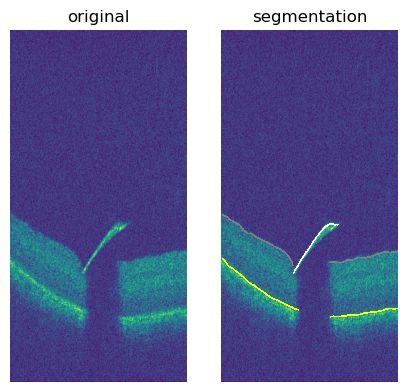

In [7]:
bscan_prefix = os.path.join(C.SPLIT_PATTERN.format(data='OP'), 'bscans', 'val')
label_prefix = os.path.join(C.SPLIT_PATTERN.format(data='OP'), 'labels', 'val')
img_name = "4ccfa695-3778-432c-834f-f368cbea695b7875-051.png"

bscan, label = get_bscan_label(img_name, bscan_prefix, label_prefix)

# label=unify_label(label, src_labels=op_label, dst_labels=U)
visualize_segmentation(bscan, label, show_original=True)

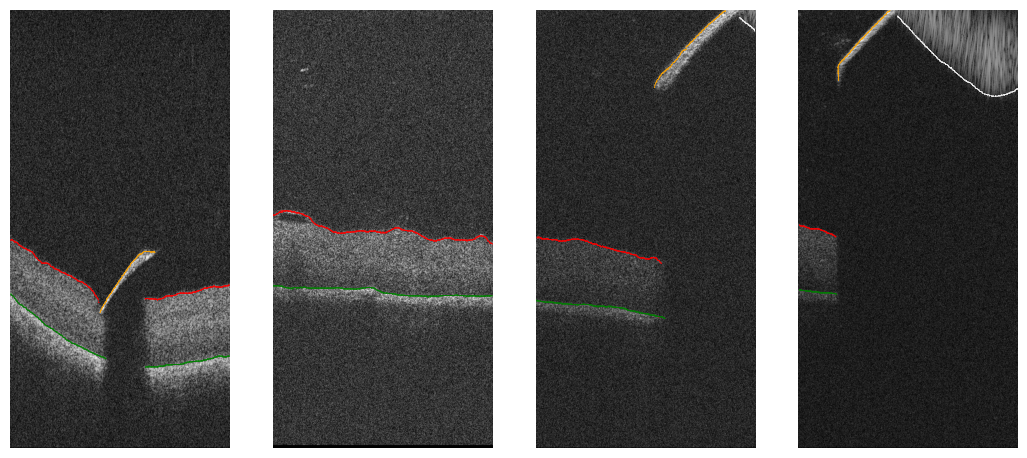

In [30]:
samples = [
    '4ccfa695-3778-432c-834f-f368cbea695b7875-051.png',
    'OS-2020-02-03_140606fs-029.png',
    'OS-2020-02-03_140322fs-064.png',
    'OS-2020-02-03_140224fs-050.png'
]

color_map = {
    1: 'orange',
    2: 'white',
    3: 'red',
    5: 'green',
}
fig, axs = plt.subplots(1, 4, figsize=(13, 9))
for i, img_name in enumerate(samples):
    bscan, label = get_bscan_label(img_name, bscan_prefix, label_prefix)
    axs[i].imshow(bscan, cmap='gray')
    axs[i].axis('off')
    for k, color in color_map.items():
        x, y = np.where(label==k)
        axs[i].scatter(y, x, color=color, alpha=0.3, linewidths=0, s=0.5)

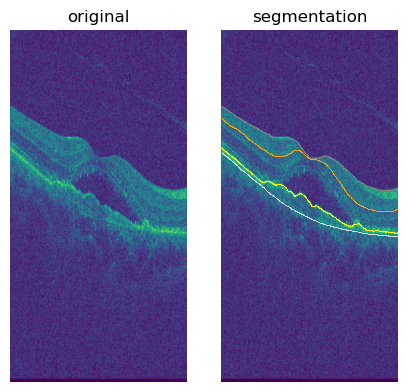

In [8]:
dst_bscan_prefix = os.path.join(C.SPLIT_PATTERN.format(data='AROI'), 'bscans', 'train') # "data/aroi/bscans/train/"
dst_label_prefix = os.path.join(C.SPLIT_PATTERN.format(data='AROI'), 'labels', 'train') # "data/aroi/labels/train/"
dst_img_name = "patient21_raw0060.png"  # "patient15_raw0032.png"
dst_bscan, dst_label = get_bscan_label(dst_img_name, dst_bscan_prefix, dst_label_prefix)
# dst_label = unify_label(dst_label, src_labels=aroi_label, dst_labels=U, remove_list=[80, 160, 240])
visualize_segmentation(dst_bscan, dst_label, show_original=True)

## Part 1: Manipulate on the bscan

The goal is the artifitialy create a cross-over image.

### Try edge detection

In [51]:
bscan = np.asarray(bscan)

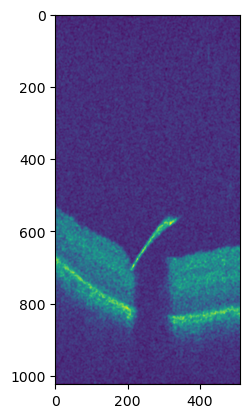

In [52]:
blurred = cv.blur(bscan,(5,5))
plt.imshow(blurred)

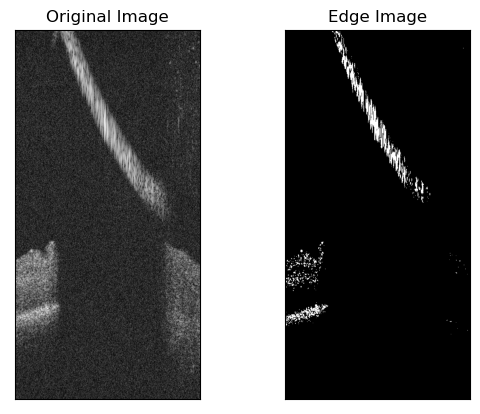

In [17]:
# edges = cv.Canny(blurred, 100, 200, L2gradient=False, apertureSize=3)
edges = bscan > 100
plt.subplot(121),plt.imshow(bscan,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Step 1: Copy and paste the tool with the manually expanded mask

Such mask is very inaccurate.

TODO:
- improve mask

#### 1. Expand instrument and mirroring label

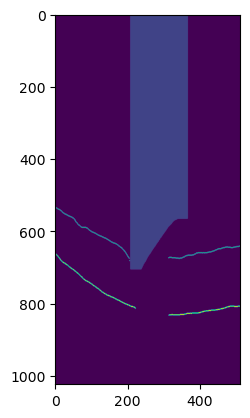

In [9]:
expanded_label = expand_label(label,
                              instrument_label=U.instrument,
                              mirror_label=U.mirror,
                              expansion_instrument=30,
                              expansion_mirror=0,
                              expand_upward=True)
plt.imshow(expanded_label)

#### 2. Cover the layers with the target label

In [10]:
def get_dst_shadow(src_label, dst_label, instrument_label=2, mirror_label=4,
                   top_layer_label=1, margin_above=0, pad_left=0, pad_right=0):
    """Get the shadow of the source label in the destination label, taking
    the instrument and shadow label in the source as well as the layer label
    in the destination into account
    Args:
    overflow_above: the margin to include above the top layer. This is for the cases
        that the human labeled top layer is inaccurate and leaves some pixels out.
    pad_left: the number of pixels to pad to the left of the shadow. This is for the
        that direct under of the instrument actually includes some layers.
    pad_right: the number of pixels to pad to the right of the shadow. This is for the
        that direct under of the instrument actually includes some layers.
    """
    img_height, img_width = src_label.shape
    shadow_x = np.array([], dtype=np.int64)
    shadow_y = np.array([], dtype=np.int64)
    # Requirements for the shadow label:
    # 1. Horizontally after the starting of the instrument/mirroring & before the
    #    ending of the instrument/mirroring
    # 2. Vertically below the upper bound of layers
    x_src_tool, y_src_tool = np.where(np.logical_or(src_label == instrument_label,
                    src_label == mirror_label))  # (1024, 512)
    if len(x_src_tool) == 0:
        return shadow_x, shadow_y
    left_bound = np.min(y_src_tool)
    right_bound = np.max(y_src_tool)
    # Detect left break and right break of the top layer, this is to adjust the left and
    # right bound of the shadow.
    for y in range(left_bound, img_width):
        # If the layer continues to present to the right of left_bound below the tools,
        # increase left_bound
        if np.any(src_label[:, y] == top_layer_label):
            left_bound = y
        else:
            break
    for y in range(right_bound, -1, -1):
        # If the layer continues to present to the left of right_bound below the tools,
        # decrease right_bound
        if np.any(src_label[:, y] == top_layer_label):
            right_bound = y
        else:
            break
    if pad_left + left_bound < right_bound:
        left_bound += pad_left
    if right_bound - pad_left > left_bound:
        right_bound -= pad_right
    accumulated_min_upperbound = 0
    for i in range(left_bound, right_bound):
        top_layer = np.where(dst_label[:, i] == top_layer_label)[0]
        if len(top_layer) == 0:
            if accumulated_min_upperbound == 0:
                continue
            else:
                # set to current recorded highest layer
                top_layer_upperbound = accumulated_min_upperbound
        else:
            # print("instrument_above", instrument_above, len(instrument_above))
            top_layer_upperbound = np.min(top_layer)
            if top_layer_upperbound - margin_above > 0:
                top_layer_upperbound -= margin_above
            if accumulated_min_upperbound == 0:
                # initialize
                accumulated_min_upperbound = top_layer_upperbound
            else:
                accumulated_min_upperbound = min(
                    accumulated_min_upperbound, top_layer_upperbound)
        x_vertical = np.arange(top_layer_upperbound,
                               img_height)  # upperbound to bottom
        y_vertical = np.full_like(x_vertical, i)
        shadow_x = np.concatenate([shadow_x, x_vertical])
        shadow_y = np.concatenate([shadow_y, y_vertical])
    return shadow_x, shadow_y

In [11]:
shadow_x, shadow_y = get_dst_shadow(expanded_label, dst_label, instrument_label=U.instrument,
                                    mirror_label=U.mirror, top_layer_label=U.ilm,
                                    margin_above=5, pad_left=10, pad_right=20)

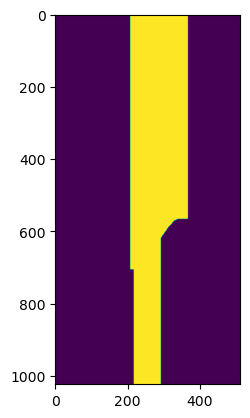

In [12]:
mask = np.full(label.shape, False)
classes_of_interest = [U.instrument, U.mirror]
for c in classes_of_interest:
    mask[expanded_label==c] = True
mask[shadow_x, shadow_y] = True
plt.imshow(mask)

#### 3. Copy and past

In [13]:
dst_bscan = np.asarray(dst_bscan)
bscan = np.asarray(bscan)

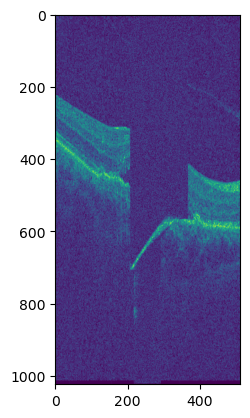

In [14]:
cross_bscan = dst_bscan.copy()
cross_bscan[mask] = bscan[mask]
# cross_bscan = np.ma.array(cross_bscan, mask=mask)
plt.imshow(cross_bscan)

## Part 2: Manipulate the label

The goal of this part is to create the corresponding label for the first part. The intuition is that it is very precise to manipulate on the label map. Then we can generate a image from the manipulated label map.

### 1. Create Cross-over labels

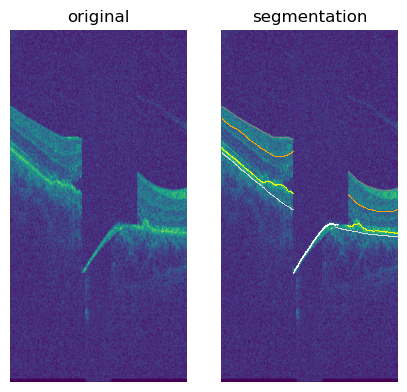

In [15]:
cross_bscan, cross_label = create_crossover(bscan, label, dst_bscan, dst_label, mask)
visualize_segmentation(cross_bscan, cross_label, show_original=True)

### 2. Expand Instrument Labels (Optional) 

Here I'll expand the instrument and mirroring labels. In previous experiment, we found out that the instruments are blurred.

The intuition is that maybe a better coverage of the label helps generate clearer instruments.

In [18]:
from idp_utils.data_handling.mask import expand_label

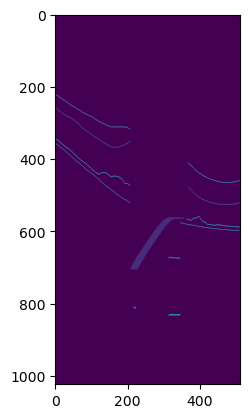

In [19]:
expanded_label = expand_label(cross_label,
                              instrument_label=U.instrument,
                              mirror_label=U.mirror,
                              expansion_instrument=20,
                              expansion_mirror=40)
plt.imshow(expanded_label)

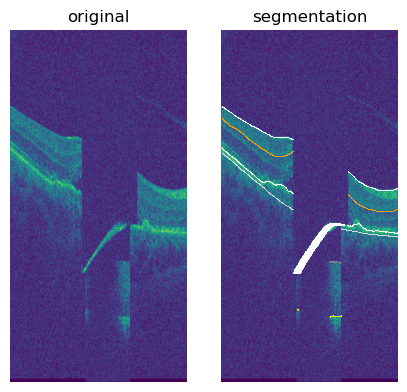

In [20]:
visualize_segmentation(cross_bscan, expanded_label, show_original=True)

## Part 3: Create a dataset

Per requirements to the [pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets), we have to create the dataset and place it using a certain format.

The ideal way is to implement a custom sampler [link](https://discuss.pytorch.org/t/how-to-generate-random-pairs-at-each-epoch/112065/2).

Here I'll do it in a simpler way.
1. Randomly choose a OP and an AROI image
2. Create a mask based on the OP and the AROI image
3. Make the cross over label and bscan
4. Save to disk

### 1. Create a pair

In [16]:
from tqdm import tqdm
import random

op_bscan_folder = os.path.join(C.SPLIT_PATTERN.format(data='OP_I'), 'bscans')
op_label_folder = os.path.join(C.SPLIT_PATTERN.format(data='OP_I'), 'labels')
aroi_bscan_folder = os.path.join(C.SPLIT_PATTERN.format(data='AROI'), 'bscans')
aroi_label_folder = os.path.join(C.SPLIT_PATTERN.format(data='AROI'), 'labels')
def sample(src_bscan_prefix, src_label_prefix, dst_bscan_prefix, bscan_label_prefix, n_pairs=1000):
    """
    Sample pairs of source and target images. Source is where we will cut the instruments and
    mirrorings, destination is where we want to preserve the layers. The passed in prefixs are
    expected to directly contain paired images respectively.
    
    Returns:
        pairs (list(tuple)): a list of tuples of paths [(src_bscan, src_label, dst_bscan, dst_label)]
    """
    pairs = []
    src_bscans = glob(os.path.join(src_bscan_prefix, '*'))
    src_labels = glob(os.path.join(src_label_prefix, '*'))
    dst_bscans = glob(os.path.join(dst_bscan_prefix, '*'))
    dst_labels = glob(os.path.join(dst_label_prefix, '*'))
    assert len(src_bscans) == len(src_labels) and len(src_bscans) != 0, f"Length mismatch for bscans and labels ({len(src_bscans)}!={len(src_labels)})"\
        f"src bscan folder: {os.path.join(src_bscan_prefix, '*')}"
    assert len(dst_bscans) == len(dst_labels) and len(dst_bscans) != 0, f"Length mismatch for bscans and labels ({len(dst_bscans)}!={len(dst_labels)})"
    for _ in tqdm(range(n_pairs)):
        src_idx = random.randrange(len(src_bscans))
        dst_idx = random.randrange(len(dst_bscans))
        src_bscan = src_bscans[src_idx]
        src_label = src_labels[src_idx]
        dst_bscan = dst_bscans[dst_idx]
        dst_label = dst_labels[dst_idx]
        pairs.append((src_bscan, src_label, dst_bscan, dst_label))
    return pairs

In [22]:
# def sample_fake(src_bscan_prefix, src_label_prefix, dst_bscan_prefix, bscan_label_prefix, known_pairs):
#     """
#     Sample pairs of source and target images. Source is where we will cut the instruments and
#     mirrorings, destination is where we want to preserve the layers. The passed in prefixs are
#     expected to directly contain paired images respectively.
    
#     Returns:
#         pairs (list(tuple)): a list of tuples of paths [(src_bscan, src_label, dst_bscan, dst_label)]
#     """
#     pairs = []

#     for src, dst in tqdm(known_pairs):
#         src_bscan = os.path.join(src_bscan_prefix, src)
#         src_label = os.path.join(src_label_prefix, src)
#         dst_bscan = os.path.join(dst_bscan_prefix, dst)
#         dst_label = os.path.join(dst_label_prefix, dst)
#         pairs.append((src_bscan, src_label, dst_bscan, dst_label))
#     return pairs

# diff_test_files = glob('data/datasets/CROSS_DIFF/test/*')
# len(diff_test_files)
# known_pairs = []
# for f in tqdm(diff_test_files):
#     combined = f.split('/')[-1]
#     dst = combined.split('-')[-1]
#     src = '-'.join(combined.split('-')[:-1]) + '.png'
#     known_pairs.append((src, dst))


# split = 'test'
# src_bscan_prefix = join(op_bscan_folder, split)
# src_label_prefix = join(op_label_folder , split)
# dst_bscan_prefix = join(aroi_bscan_folder, split)
# dst_label_prefix = join(aroi_label_folder, split)
# sampled_test = sample_fake(src_bscan_prefix, src_label_prefix, dst_bscan_prefix, dst_label_prefix, known_pairs)
# sampled_pairs = {'test': sampled_test}

In [30]:
# sampled_pairs = {}
# for split, n_pairs in zip(['train', 'val', 'test'], [1000, 100, 100]):
#     src_bscan_prefix = join(op_bscan_folder, split)
#     src_label_prefix = join(op_label_folder , split)
#     dst_bscan_prefix = join(aroi_bscan_folder, split)
#     dst_label_prefix = join(aroi_label_folder, split)
#     sampled_pairs[split] = sample(src_bscan_prefix, src_label_prefix, dst_bscan_prefix, dst_label_prefix, n_pairs)

In [32]:
# import pickle

# with open('sampled.pkl', 'wb') as f:
#     pickle.dump(sampled_pairs, f)

In [17]:
import pickle
with open('sampled.pkl', 'rb') as f:
    sampled_pairs = pickle.load(f)

In [18]:
from collections import defaultdict
new_sampled = defaultdict(list)
for split, pairs in sampled_pairs.items():
   for p in pairs:
       new_sampled[split].append(tuple(i.replace('AROI_H', 'AROI') for i in p))

In [19]:
sampled_pairs = new_sampled

### 2. Create a mask for a pair

In [20]:
def load_as_array(img_path, label_type=None):
    """Load the image from a path to a numpy array
    If label type is set, it will convert and unify the label.
    label_type accepts None or op or aroi
    """
    img = Image.open(img_path)
    img_arr = np.asarray(img)
    if label_type == 'op':
        # img_arr = unify_label(img_arr, src_labels=op_label, dst_labels=U)
        modified_img_arr = np.array(img)  # remove layers from OP
        modified_img_arr[img_arr == U.ilm] = 0
        modified_img_arr[img_arr == U.rpe] = 0
        modified_img_arr[img_arr == D.ilm] = 0
        modified_img_arr[img_arr == D.rpe] = 0
        img_arr = modified_img_arr
    # elif label_type == 'aroi':
    #     img_arr = unify_label(img_arr, src_labels=aroi_label, dst_labels=U, remove_list=[80, 160, 240])
    return img_arr

def create_mask(src_bscan, src_label, dst_bscan, dst_label):
    # 2. expand source label
    expanded_src_label = expand_label(src_label,
                                      instrument_label=U.instrument,
                                      mirror_label=U.mirror,
                                      expansion_instrument=30,
                                      expansion_mirror=0,
                                      expand_upward=True)
    # 3. get shadowed area based on the dst label
    shadow_x, shadow_y = get_dst_shadow(expanded_src_label,
                                        dst_label,
                                        instrument_label=U.instrument,
                                        mirror_label=U.mirror,
                                        top_layer_label=U.ilm, # for hetero aroi, this is D.ilm, otherwise U.ilm
                                        margin_above=20,
                                        pad_left=10,
                                        pad_right=15)
    # 4. create the mask
    mask = np.full(src_bscan.shape, False)
    classes_of_interest = [U.instrument, U.mirror]
    for c in classes_of_interest:
        mask[expanded_src_label==c] = True
    mask[shadow_x, shadow_y] = True
    return mask

### 3. Create cross over bscan and label

In [21]:
def create_crossover(src_bscan, src_label, dst_bscan, dst_label, mask, ):
    cross_bscan = dst_bscan.copy()
    cross_bscan[mask] = src_bscan[mask]
    cross_label = dst_label.copy()
    # remove layers from src_label (op)
    # src_label_copy = src_label.copy()
    # src_label_copy[src_label == D.ilm] = 0
    # src_label_copy[src_label == D.rpe] = 0
    # src_label_copy[src_label == U.ilm] = 0
    # src_label_copy[src_label == U.rpe] = 0
    cross_label[mask] = src_label[mask]
    return cross_bscan, cross_label

('data/splits/OP_I/bscans/train/OS-2020-02-03_135535fs-037.png', 'data/splits/OP_I/labels/train/OS-2020-02-03_135535fs-037.png', 'data/splits/AROI/bscans/train/patient18_raw0051.png', 'data/splits/AROI/labels/train/patient18_raw0051.png')


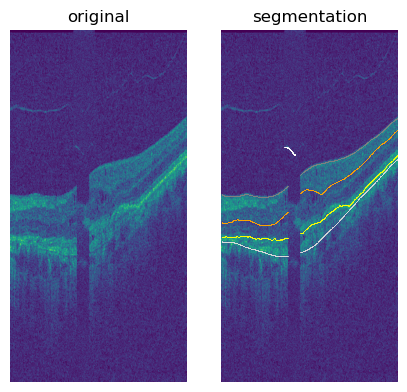

In [40]:
sampled_pair = sampled_pairs['train'][36]
print(sampled_pair)
src_bscan_path, src_label_path, dst_bscan_path, dst_label_path = sampled_pair
loaded_pair = (
    load_as_array(src_bscan_path),
    load_as_array(src_label_path, label_type='op'),
    load_as_array(dst_bscan_path),
    load_as_array(dst_label_path, label_type='aroi')    
)
mask = create_mask(*loaded_pair)
cross_bscan, cross_label = create_crossover(*loaded_pair, mask)


# optional: expand cross label
# cross_label = expand_label(cross_label,
#                            instrument_label=U.instrument,
#                            mirror_label=U.mirror,
#                            expansion_instrument=20,
#                            expansion_mirror=40)
visualize_segmentation(cross_bscan, cross_label, show_original=True)

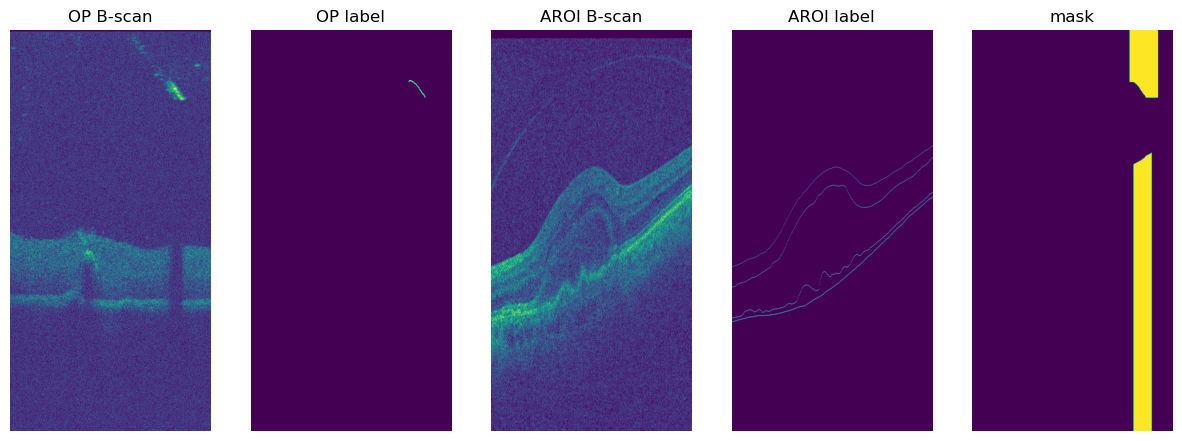

In [39]:
plot_horizontal(loaded_pair+( mask,),
                ['OP B-scan', 'OP label', 'AROI B-scan', 'AROI label', 'mask'],
                figsize=(15, 6))
plt.savefig('images/mask3.png', bbox_inches='tight', pad_inches=0)

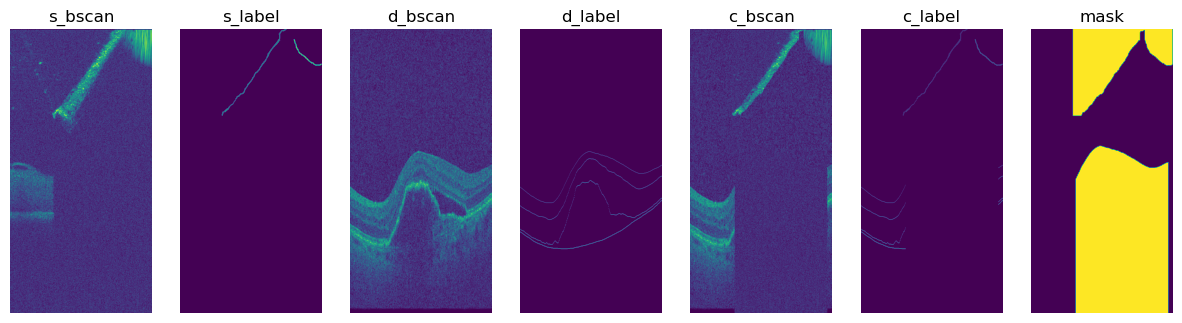

In [24]:
plot_horizontal(loaded_pair+(cross_bscan, cross_label, mask),
                ['s_bscan', 's_label', 'd_bscan', 'd_label', 'c_bscan', 'c_label', 'mask'],
                figsize=(15, 4))

### 4. Mass produce a dataset

In [65]:
cross_dataset_path = C.SPLIT_PATTERN.format(data='cross')
for typ in ['bscans', 'labels']:
    for split in ['test']: # 'train', 'val', 
        data_dir = join(cross_dataset_path, typ, split)
        Path(data_dir).mkdir(parents=True, exist_ok=True)

In [67]:
from os.path import basename
def create_cross_pair(src_bscan_path, src_label_path, dst_bscan_path, dst_label_path, expand=False):
    loaded_pair = (
        load_as_array(src_bscan_path),
        load_as_array(src_label_path, label_type='op'),
        load_as_array(dst_bscan_path),
        load_as_array(dst_label_path, label_type='aroi')    
    )
    mask = create_mask(*loaded_pair)
    cross_bscan, cross_label = create_crossover(*loaded_pair, mask)
    if expand:
        cross_label = expand_label(cross_label,
                                   instrument_label=U.instrument,
                                   mirror_label=U.mirror,
                                   expansion_instrument=20,
                                   expansion_mirror=40)
    return cross_bscan, cross_label

In [68]:
expanded_cross_dataset_path = C.SPLIT_PATTERN.format(data='cross')
for typ in ['bscans', 'labels']:
    for split in [ 'test']: # 'train', 'val',
        data_dir = join(expanded_cross_dataset_path, typ, split)
        Path(data_dir).mkdir(parents=True, exist_ok=True)
bscan_dir = join(expanded_cross_dataset_path, 'bscans')
label_dir = join(expanded_cross_dataset_path, 'labels')

for split in ['test']: # 'train', 'val', 
    sampled_pair = sampled_pairs[split]
    for pair in tqdm(sampled_pair):
        cross_bscan, cross_label = create_cross_pair(*pair, expand=True)
        cross_bscan = Image.fromarray(cross_bscan, mode='L')
        cross_label = Image.fromarray(cross_label, mode='L')
        img_name = basename(pair[0]).split('.')[-2] + '-' + basename(pair[2]).split('.')[-2] + '.png'
        cross_bscan.save(os.path.join(bscan_dir, split, img_name))
        cross_label.save(os.path.join(label_dir, split, img_name))

100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


## Part 4. Train a pix2pix on the artifitially generated images

Check [pix2pix train/test](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix#pix2pix-traintest)

### 1. Create a dataset with the dataset creation script

`python datasets/combine_A_and_B.py --fold_A /path/to/data/A --fold_B /path/to/data/B --fold_AB /path/to/data`

In [69]:
cross_combined_dir = C.DATASET_PATTERN.format(data='CROSS')
!mkdir -p $cross_combined_dir
cross_combined_dir

'data/datasets/CROSS'

In [70]:
# !rm -rf $cross_combined_dir

In [71]:
!echo label_dir: $label_dir
!echo bscan_dir: $bscan_dir
!echo cross_combined_dir: $cross_combined_dir

label_dir: data/splits/cross/labels
bscan_dir: data/splits/cross/bscans
cross_combined_dir: data/datasets/CROSS


In [72]:
!python submodules/pix2pix/datasets/combine_A_and_B.py --fold_A $label_dir --fold_B $bscan_dir --fold_AB $cross_combined_dir --grayscale

[fold_A] =  data/splits/cross/labels
[fold_B] =  data/splits/cross/bscans
[fold_AB] =  data/datasets/CROSS
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
[grayscale] =  True
split = train, use 4996/4996 images
split = train, number of images = 4996
split = val, use 498/498 images
split = val, number of images = 498
split = test_old, use 1/1 images
split = test_old, number of images = 1
split = test, use 99/99 images
split = test, number of images = 99


In [118]:
# expaned
expanded_cross_combined_dir = C.DATASET_PATTERN.format(data='CROSS')
!echo label_dir: $label_dir
!echo bscan_dir: $bscan_dir
!echo expanded_cross_combined_dir: $expanded_cross_combined_dir

label_dir: data/splits/cross/labels
bscan_dir: data/splits/cross/bscans
expanded_cross_combined_dir: data/datasets/CROSS


In [ ]:
!python submodules/pix2pix/datasets/combine_A_and_B.py --fold_A $label_dir --fold_B $bscan_dir --fold_AB $expanded_cross_combined_dir --grayscale

### 2. Train a pix2pix model

`python train.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --direction BtoA`

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/train.py  --help

#### Vanilla cross label

--name was `pix_fused`

```verbose log
----------------- Options ---------------
               batch_size: 64                            	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: data/datasets/cross_large_pix 	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: True                          	[default: None]
                lambda_L1: 100.0                         
                load_iter: 0                             	[default: 0]
                load_size: 286                           
                       lr: 0.0002                        
           lr_decay_iters: 50                            
                lr_policy: linear                        
         max_dataset_size: inf                           
                    model: pix2pix                       	[default: cycle_gan]
                 n_epochs: 400                           	[default: 100]
           n_epochs_decay: 100                           
               n_layers_D: 3                             
                     name: cross_large_pix               	[default: experiment_name]
                      ndf: 64                            
                     netD: basic                         
                     netG: unet_256                      
                      ngf: 64                            
               no_dropout: False                         
                  no_flip: False                         
                  no_html: False                         
                     norm: batch                         
              num_threads: 4                             
                output_nc: 3                             
                    phase: train                         
                pool_size: 0                             
               preprocess: resize_and_crop               
               print_freq: 500                           	[default: 100]
             save_by_iter: False                         
          save_epoch_freq: 20                            	[default: 5]
         save_latest_freq: 5000                          
           serial_batches: False                         
                   suffix:                               
         update_html_freq: 1000                          
                use_wandb: False                         
                  verbose: False       
```

In [121]:
!CUDA_VISIBLE_DEVICES=3 python -W ignore submodules/pix2pix/train.py \
    --dataroot $cross_combined_dir \
    --name cross \
    --model pix2pix \
    --direction AtoB \
    --n_epochs 100 \
    --print_freq 500 \
    --batch_size 512 \
    --save_epoch_freq 20 \
    --num_threads 32 \
    --use_wandb
    

unknown option --dataroot
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


#### Expanded labels

In [ ]:
# train with expanded
!CUDA_VISIBLE_DEVICES=3 python -W submodules/pix2pix/train.py \
    --dataroot $expanded_cross_combined_dir \
    --name "expanded_pix_fused" \
    --model pix2pix \
    --direction AtoB \
    --n_epochs 400 \
    --print_freq 500 \
    --batch_size 128 \
    --save_epoch_freq 20

#### One-hot input

We train a model with `input_nc=n_labels`, `output_nc=1` and `dataset_mode=oct_dataset`

In [ ]:
dataroot = 'data/datasets/cross_combined'
name = 'onehot_cross_pix'

In [ ]:
!echo $dataroot
!CUDA_VISIBLE_DEVICES=1 python submodules/pix2pix/train.py \
    --dataroot $dataroot \
    --name $name \
    --model pix2pix \
    --direction AtoB \
    --n_epochs 100 \
    --print_freq 500 \
    --batch_size 64 \
    --save_epoch_freq 20 \
    --input_nc 7 \
    --output_nc 1 \
    --dataset_mode oct

In [ ]:
name = 'onehot_cross_pix_o3'
!echo $dataroot
!CUDA_VISIBLE_DEVICES=1 python submodules/pix2pix/train.py \
    --dataroot $dataroot \
    --name $name \
    --model pix2pix \
    --direction AtoB \
    --n_epochs 200 \
    --print_freq 500 \
    --batch_size 64 \
    --save_epoch_freq 20 \
    --input_nc 7 \
    --output_nc 3 \
    --dataset_mode oct

## Part 5: Test the Trained Model

Results are saved at `./results/pix_fused/test_{epoch}`

Evaluate on the cross diff data

In [ ]:
cross_diff_dataset = 'data/datasets/CROSS_DIFF'

for ep in [ 40, 80, 200]:
    !python -W ignore submodules/pix2pix/test.py \
        --dataroot $cross_diff_dataset \
        --name "pix2pix_oparoi_diff" \
        --model pix2pix \
        --direction AtoB \
        --epoch {ep} \
        --results_dir "results/pix2pix_oparoi_diff" \
        --num_test 100 \
        --gpu_ids 3

Evaluate the homogeneous model on cross combined data:

In [ ]:
%%bash

export cross_dataset='data/datasets/CROSS'

for ep in 20 40 80 140 200
do
    python -W ignore submodules/pix2pix/test.py \
        --dataroot $cross_dataset \
        --name "cross" \
        --model pix2pix \
        --direction AtoB \
        --epoch $ep \
        --results_dir "results/cross_homo" \
        --num_test 100\
        --gpu_ids 2
done

Mixed training with different labels:

In [ ]:
%%bash

export cross_dataset='data/datasets/CROSS_DIFF'

for ep in 100 200
do
    python -W ignore submodules/pix2pix/test.py \
        --dataroot $cross_dataset \
        --name pix2pix_oparoi_diff \
        --model pix2pix \
        --direction AtoB \
        --epoch $ep \
        --results_dir "results/oparoi_diff" \
        --num_test 100\
        --gpu_ids 2
done

Fused training:

In [ ]:
%%bash

export cross_dataset='data/datasets/CROSS'

for ep in 50 200 500
do
    python -W ignore submodules/pix2pix/test.py \
        --dataroot $cross_dataset \
        --name "pix" \
        --model pix2pix \
        --direction AtoB \
        --epoch $ep \
        --results_dir "results/cross_homo" \
        --num_test 100\
        --gpu_ids 2
done

In [ ]:
uop_dataset_dir = C.DATASET_PATTERN.format(data='uop')
uop_dataset_dir

Evaluate the model with expanded instrument label on iOCT:

In [ ]:
uop_dataset_dir = C.DATASET_PATTERN.format(data='uop')
for ep in [20, 40, 60, 140, 300]:
    !CUDA_VISIBLE_DEVICES=1 python pytorch-CycleGAN-and-pix2pix/test.py  \
        --dataroot $uop_dataset_dir \
        --name "expanded_pix_fused" \
        --model pix2pix \
        --direction AtoB \
        --epoch {ep} \
        --batch_size 10 \
        --results_dir "./results/expanded_pix_fused"

Evaluate the model with onehot label:

In [ ]:
uop_dataset_dir = C.DATASET_PATTERN.format(data='uop')
name = 'onehot_cross_pix'
results_dir = "./results/" + name
for ep in [200]:
    !CUDA_VISIBLE_DEVICES=1 python submodules/pix2pix/test.py  \
        --dataroot $uop_dataset_dir \
        --name $name \
        --model pix2pix \
        --direction AtoB \
        --epoch {ep} \
        --batch_size 10 \
        --results_dir $results_dir \
        --input_nc 7 \
        --output_nc 1 \
        --dataset_mode oct

In [ ]:
im = np.zeros((4,4))#.astype(np.float64)

In [ ]:
from PIL import Image
im_pil = Image.fromarray(im)
im_pil = im_pil.convert('RGB')

In [ ]:
im_pil.save('test.png')

## Create a common eval dataset

In [162]:
cross_files = glob('data/datasets/CROSS/test/*') + glob('data/datasets/CROSS/train/*') + glob('data/datasets/CROSS/val/*')
cross_files = [f.split('/')[-1] for f in cross_files]
len(cross_files)

5495

In [164]:
cross_diff_files = glob('data/datasets/CROSS_DIFF/test/*') + glob('data/datasets/CROSS_DIFF/train/*') + glob('data/datasets/CROSS_DIFF/val/*')
cross_diff_files = [f.split('/')[-1] for f in cross_diff_files]
len(cross_diff_files)

1199

In [166]:
common = list(set(cross_files).intersection(set(cross_diff_files)))
len(common)

4

In [159]:
for f in cross_files:
    if f.split('/')[-1] not in common:
        os.remove(f)

In [151]:
cross_files[0]

'test/OS-2020-02-03_114037fs-026-patient15_raw0070.png'